[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ninarina12/NX-School-2023/blob/main/AI-ML_Tutorial.ipynb)

# Introduction to AI-ML Applications for X-ray Experiments
This tutorial describes an introductory-level AI/ML application to assist an experimental workflow inspired by the work of [Starodub *et al*](https://www.nature.com/articles/ncomms2288). In this work, the authors used ultra-short, intense X-ray pulses from an X-ray free-electron laser (FEL) to obtain single-shot diffraction patterns of polystyrene sphere aggregates. These aggregates vary in size from one to multiple spheres and need to be sorted prior to further analysis.

In this tutorial, we will demonstrate how different machine learning techniques can be used to automate and accelerate this type of workflow, including:
- Building a simple convolutional neural network to classify synthetic diffraction patterns of sphere aggregates by the corresponding aggregate size (*i.e.* number of spheres).
- Using clustering methods to differentiate and sort diffraction patterns.
- Streamlining the coding process by using ChatGPT to propose code for specific tasks such as generating training data of the target system, building the neural network architecture, and writing a training loop with helpful checkpoints.

![background.png](background.png)

## Generation of synthetic objects and diffraction patterns

### Use ChatGPT to make a generator for custom image data

We will use ChatGPT to write a generator for image data resembling the spherical aggregates. For simplicity, we will work in two-dimensions and generate the projection of spherical aggregates on a two-dimensional plane perpendicular to the beam direction.

#### ChatGPT Prompt:
Write a python script using numpy arrays that generates $N \times N$ images with 1-5 randomly-placed circles of a user-provided radius, all of which either touch or overlap one another. Ensure that the first circle is placed within the center $N/2 \times N/2$ pixels of the image.

In [1]:
import numpy as np

def generate_image(N, num_circles, radius):
    if num_circles < 1 or num_circles > 5:
        raise ValueError("Number of circles should be between 1 and 5.")

    # Create an empty NxN image
    image = np.zeros((N, N))

    # Function to generate a circle within an image
    def draw_circle(img, center, rad):
        Y, X = np.ogrid[:img.shape[0], :img.shape[1]]
        dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
        mask = dist_from_center <= rad
        img[mask] += 1

    # Generate the first circle in the center N/2 x N/2 pixels
    center_x = np.random.randint(N/4, 3*N/4)
    center_y = np.random.randint(N/4, 3*N/4)
    centers = [(center_x, center_y)]
    draw_circle(image, centers[0], radius)

    for _ in range(1, num_circles):
        # Randomly select an existing circle
        ref_center = centers[np.random.choice(len(centers))]

        # Generate a random angle to place the new circle
        angle = 2 * np.pi * np.random.rand()

        # Calculate the center of the new circle based on the angle and 2*radius distance
        new_center_x = ref_center[0] + 2 * radius * np.cos(angle)
        new_center_y = ref_center[1] + 2 * radius * np.sin(angle)
        
        # Handle boundaries
        new_center_x = min(max(radius, new_center_x), N - radius)
        new_center_y = min(max(radius, new_center_y), N - radius)

        centers.append((new_center_x, new_center_y))
        draw_circle(image, (new_center_x, new_center_y), radius)

    return image

Below, we define a short custom plotting function in order to visualize examples of the generated images.

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_object(obj, label=0):
    fig, ax = plt.subplots(figsize=(3,3))
    
    ax.imshow(obj, origin='lower', cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    
    if label:
        ax.text(0.9, 0.1, 'n = ' + str(label), color='white', ha='right', va='bottom', transform=ax.transAxes)
        
    return fig

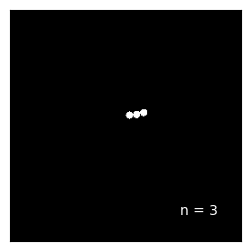

In [3]:
# Generate real-space object
N = 256
num_circles = 3
radius = 4
obj = generate_image(N, num_circles, radius)

# Plot object
fig = plot_object(obj, num_circles)

### Write custom functions to generate diffraction patterns from generated images
The diffracted intensity is well-approximated by the square modulus of the Fourier transform, i.e.
$$ I(\mathbf{q}) = |\mathcal{F}\{\mathcal{O}(\mathbf{r})\}|^2,$$
where $\mathcal{F}$ denotes the Fourier transform.

Additionally, experimental data are often corrupted by Poisson noise; thus, instead of using the perfect calculated diffraction intensity, we can use it to sample from a Poisson distribution in which the intensity acts as a proxy for the expected event frequency $\lambda$.

To accomplish this in a systematic way, we will first calculate perfect diffraction patterns and normalize them by the maximum value. Then, we will scale the image by a factor $\lambda_{max}$, the maximum expected event frequency, and resample each pixel from the Poisson distribution with $\lambda$ given by the pixel value.

In [4]:
def fourier_transform(obj):
    # Perform a 2D FFT
    return np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(obj)))

def calculate_diffraction_pattern(obj, lambda_max=1e3):
    # Calculate the diffracted intensity from a given object, and normalize by the maximum value
    diff = np.abs(fourier_transform(obj))**2
    diff /= diff.max()
    
    # Scale by the maximum expected event frequency (intensity) and corrupt with poisson noise
    return np.random.poisson(lambda_max*diff)

We also add a plotting function for visualizing the object and corresponding diffraction pattern.

In [5]:
def plot_object_and_pattern(obj, diff, label=0):
    fig, ax = plt.subplots(1,3, figsize=(6.25,3), gridspec_kw={'width_ratios': [1,1,0.05]})
    fig.subplots_adjust(wspace=0.1)
    
    cmap = plt.cm.bone
    vmax = 10**np.round(np.log10(diff.max()))
    norm = mpl.colors.LogNorm(vmin=1., vmax=vmax, clip=True)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

    ax[0].imshow(obj, origin='lower', cmap='gray')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    if label:
        ax[0].text(0.9, 0.1, 'n = ' + str(label), color='white', ha='right', va='bottom', transform=ax[0].transAxes)

    ax[1].imshow(diff, origin='lower', cmap=cmap, norm=norm)
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    plt.colorbar(sm, cax=ax[2])
    return fig

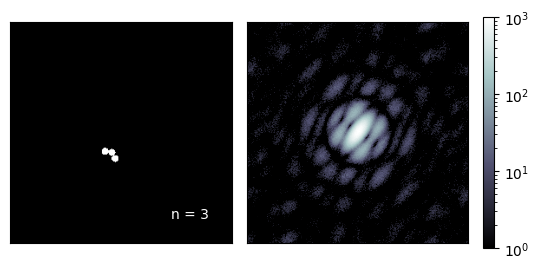

In [6]:
# Generate real-space object
N = 256
num_circles = 3
radius = 4
obj = generate_image(N, num_circles, radius)

# Calculate diffraction pattern
lambda_max = 1e3
diff = calculate_diffraction_pattern(obj, lambda_max)

# Plot pattern
fig = plot_object_and_pattern(obj, diff, num_circles)

### Write a loop to generate a dataset of object images and diffraction patterns
Now we want to construct a large, labeled dataset to be used for machine learning. To do this, we will randomly sample the aggregate size, `num_circles`, at each iteration and then randomly generate the corresponding object and its diffraction pattern. We will also define the class or label of each image as `num_circles - 1` in order to index the classes starting from 0.

In [7]:
from tqdm import tqdm

num_images = 1000
objs = np.zeros((num_images, N, N))
diffs = np.zeros_like(objs)
targets = np.zeros((num_images,), dtype=int)

for i in tqdm(range(num_images), desc="Generating image data"):
    # Randomly select number of circles to generate
    num_circles = np.random.randint(1,6)
    targets[i] = num_circles - 1
    
    # Generate real-space image
    objs[i] = generate_image(N, num_circles, radius)
    
    # Calculate diffraction pattern
    diffs[i] = calculate_diffraction_pattern(objs[i], lambda_max)

Generating image data: 100%|███████████████| 1000/1000 [00:04<00:00, 212.82it/s]


We also add a plotting function for visualizing a subset of randomly-selected diffraction patterns from the dataset.

In [8]:
def plot_pattern_grid(diffs, labels=None):
    fig, ax = plt.subplots(4,5, figsize=(8,8), gridspec_kw={'width_ratios': [1]*4 + [0.05]})
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    axes = ax[:,:-1].ravel()

    indices = np.random.randint(len(diffs), size=16)

    cmap = plt.cm.bone
    vmax = 10**np.round(np.log10(diffs.max()))
    norm = mpl.colors.LogNorm(vmin=1., vmax=vmax, clip=True)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

    for i, index in enumerate(indices):
        axes[i].imshow(diffs[index], origin='lower', cmap=cmap, norm=norm)
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    for i in range(3):
        ax[i,-1].remove()
    
    try: len(labels)
    except: pass
    else:
        for i, index in enumerate(indices):
            axes[i].text(0.9, 0.1, 'n = ' + str(labels[index]), color='white', ha='right', va='bottom',
                         transform=axes[i].transAxes)
        
    plt.colorbar(sm, cax=ax[-1,-1])
    return fig

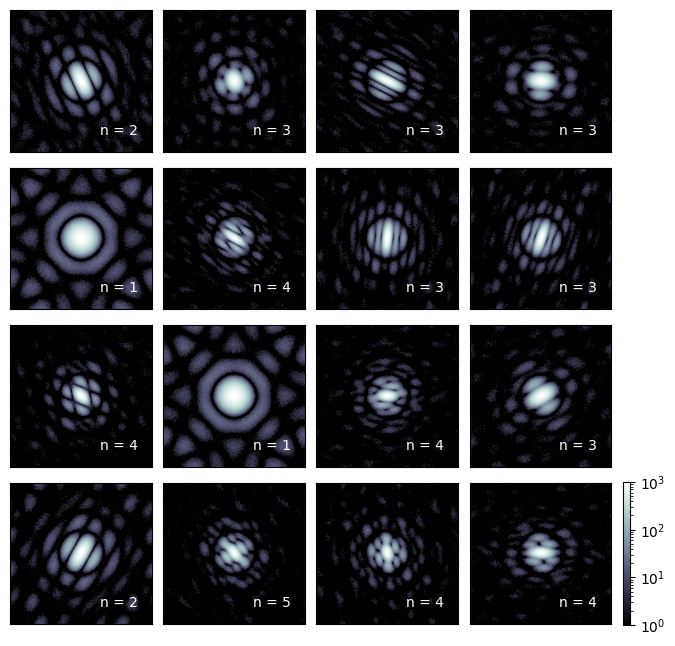

In [9]:
fig = plot_pattern_grid(diffs, targets + 1)

## Part A: Image classification with convolutional neural networks (CNNs)

### Use ChatGPT to build a simple CNN classifier
We will use the `PyTorch` library to build and train a neural network classifier. Let's use ChatGPT to recommend a neural network architecture for classifying the diffraction patterns into one of five classes.

#### ChatGPT Prompt:
Make a neural network model in PyTorch that classifies $N \times N$ grayscale images into 5 classes.

In [15]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, N):
        super(SimpleCNN, self).__init__()

        # Assuming grayscale image so input channels = 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=64 * (N//4) * (N//4), out_features=128)  # after two max-pooling layers
        self.fc2 = nn.Linear(in_features=128, out_features=5)  # 5 classes
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)

        x = self.relu(self.conv2(x))
        x = self.maxpool(x)

        x = x.view(x.size(0), -1)  # flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
print(SimpleCNN(N))

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=262144, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)


### Prepare data for training
Split our data into training, validation, and testing datasets and define data loaders for feeding data to the model in smaller batches.

In [12]:
from torch.utils.data import DataLoader, TensorDataset, random_split

torch.set_default_dtype(torch.float64)

# Define sizes of the training, validation, and testing datasets as well as batch size
val_size = int(0.1 * num_images)
test_size = int(0.1 * num_images)
train_size = num_images - val_size - test_size
batch_size = 32

# Convert arrays to torch tensors; note the insertion of an extra dimension - the channel dimension - for convolution
dataset = TensorDataset(torch.from_numpy(diffs).unsqueeze(1), torch.from_numpy(targets))
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Format dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Use ChatGPT to write a training loop for the CNN
Let's use ChatGPT to recommend the training protocol for the CNN; for example, what loss function, learning rate, and number of iterations or epochs to use as a starting point. We can also ask for the loss to be recorded after each epoch in order to inspect the training history.

#### ChatGPT Prompt:
Write the training loop to optimize the CNN, which displays a progress bar and prints the current accuracy on the training and validation datasets for each epoch. Also save the training and validation losses and accuracies at each epoch to lists.

In [17]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(N).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Progress bar with tqdm
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    train_accuracy = correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Evaluate on validation data
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    print(f"Training Loss: {train_losses[-1]:.3f}, Training Accuracy: {train_accuracy*100:.2f}%,",
          f"Validation Loss: {val_losses[-1]:.3f}, Validation Accuracy: {val_accuracy*100:.2f}%")

Epoch 1/10: 100%|███████████████████████████████| 25/25 [00:05<00:00,  4.67it/s]


Training Loss: 14.287, Training Accuracy: 42.12%, Validation Loss: 0.899, Validation Accuracy: 66.00%


Epoch 2/10: 100%|███████████████████████████████| 25/25 [00:05<00:00,  4.69it/s]


Training Loss: 0.738, Training Accuracy: 68.62%, Validation Loss: 0.545, Validation Accuracy: 83.00%


Epoch 3/10: 100%|███████████████████████████████| 25/25 [00:05<00:00,  4.70it/s]


Training Loss: 0.446, Training Accuracy: 81.38%, Validation Loss: 0.376, Validation Accuracy: 87.00%


Epoch 4/10: 100%|███████████████████████████████| 25/25 [00:05<00:00,  4.72it/s]


Training Loss: 0.357, Training Accuracy: 85.38%, Validation Loss: 0.394, Validation Accuracy: 86.00%


Epoch 5/10: 100%|███████████████████████████████| 25/25 [00:05<00:00,  4.71it/s]


Training Loss: 0.204, Training Accuracy: 93.00%, Validation Loss: 0.308, Validation Accuracy: 92.00%


Epoch 6/10: 100%|███████████████████████████████| 25/25 [00:05<00:00,  4.69it/s]


Training Loss: 0.169, Training Accuracy: 93.00%, Validation Loss: 0.379, Validation Accuracy: 89.00%


Epoch 7/10: 100%|███████████████████████████████| 25/25 [00:05<00:00,  4.69it/s]


Training Loss: 0.193, Training Accuracy: 93.38%, Validation Loss: 0.334, Validation Accuracy: 92.00%


Epoch 8/10: 100%|███████████████████████████████| 25/25 [00:05<00:00,  4.69it/s]


Training Loss: 0.099, Training Accuracy: 96.25%, Validation Loss: 0.390, Validation Accuracy: 89.00%


Epoch 9/10: 100%|███████████████████████████████| 25/25 [00:05<00:00,  4.68it/s]


Training Loss: 0.084, Training Accuracy: 97.12%, Validation Loss: 0.359, Validation Accuracy: 89.00%


Epoch 10/10: 100%|██████████████████████████████| 25/25 [00:05<00:00,  4.68it/s]


Training Loss: 0.069, Training Accuracy: 97.38%, Validation Loss: 0.380, Validation Accuracy: 90.00%


Plot the evolution of the loss and accuracy over the course of training.

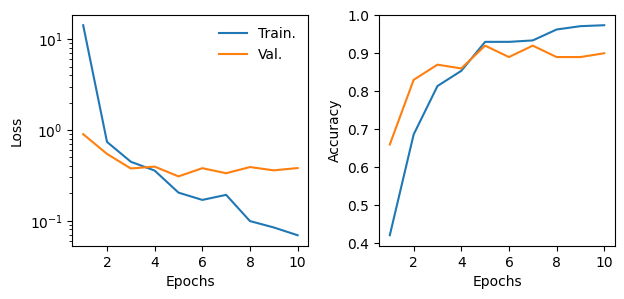

In [19]:
fig, ax = plt.subplots(1,2, figsize=(7,3))
fig.subplots_adjust(wspace=0.3)
ax[0].plot(range(1, len(train_losses) + 1), train_losses, label='Train.')
ax[0].plot(range(1, len(val_losses) + 1), val_losses, label='Val.')
ax[0].set_yscale('log')

ax[1].plot(range(1, len(train_accuracies) + 1), train_accuracies)
ax[1].plot(range(1, len(val_accuracies) + 1), val_accuracies)

ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy');

### Questions
- How do modifications to the model architecture affect performance; for instance, changing the dropout rate, adding convolution and pooling layers, etc.?
- The bigger the aggregate size, the more variations we can observe in the diffraction patterns due to reduced rotational symmetry. What are some strategies to account for this imbalance between the different class labels?